# Knapsack — Multiple Knapsacks & Multidimensional Constraints

In [1]:

# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Fixed random seed for reproducibility
np.random.seed(42)

# Parameters
NUM_KNAPSACKS = 2
NUM_ITEMS = 10
NUM_DIMENSIONS = 2

# Generate random values and weights
VALUES = np.random.randint(10, 100, size=NUM_ITEMS)
WEIGHTS = np.random.randint(5, 50, size=(NUM_ITEMS, NUM_DIMENSIONS))
CONSTRAINTS = np.random.randint(80, 150, size=(NUM_KNAPSACKS, NUM_DIMENSIONS))

print("Values:", VALUES)
print("Weights:\n", WEIGHTS)
print("Constraints:\n", CONSTRAINTS)


Values: [61 24 81 70 30 92 96 84 84 97]
Weights:
 [[40 44]
 [28  7]
 [26  6]
 [28 48]
 [34 42]
 [ 6 25]
 [37 16]
 [26 48]
 [29 31]
 [46 32]]
Constraints:
 [[139  94]
 [141 141]]


In [2]:

# Generate a random feasible solution (each item in at most one knapsack)
solution = np.zeros((NUM_KNAPSACKS, NUM_ITEMS), dtype=bool)
for i in range(NUM_ITEMS):
    k = np.random.choice(NUM_KNAPSACKS + 1)  # +1 means possibly not included
    if k < NUM_KNAPSACKS:
        solution[k, i] = True

# Check constraints and feasibility
def check_feasibility(solution):
    valid = True
    for k in range(NUM_KNAPSACKS):
        if np.any(WEIGHTS[solution[k]].sum(axis=0) > CONSTRAINTS[k]):
            valid = False
    if np.any(solution.sum(axis=0) > 1):
        valid = False
    return valid

print("Feasible initial solution:", check_feasibility(solution))


Feasible initial solution: True


## Problem 1: 0/1 Multi-Knapsack (Dynamic Programming Style)

In [3]:

# Simple 0/1 approach: try to fill each knapsack with items not exceeding constraints
def multi_knapsack_01(values, weights, constraints):
    num_knaps, num_items = constraints.shape[0], values.shape[0]
    assignment = np.zeros((num_knaps, num_items), dtype=bool)
    remaining = constraints.copy()
    used = np.zeros(num_items, dtype=bool)

    for k in range(num_knaps):
        for i in np.argsort(-values):  # sort by value descending
            if not used[i] and np.all(weights[i] <= remaining[k]):
                assignment[k, i] = True
                remaining[k] -= weights[i]
                used[i] = True
    total_value = (assignment * values).sum()
    return assignment, total_value

solution_01, val_01 = multi_knapsack_01(VALUES, WEIGHTS, CONSTRAINTS)
print("0/1 Knapsack value:", val_01)
print("Assignment:\n", solution_01)


0/1 Knapsack value: 628
Assignment:
 [[False False  True False False  True  True False False  True]
 [False  True False  True False False False  True  True False]]


## Problem 2: Fractional Multi-Knapsack (Greedy by Value/Weight Ratio)

In [5]:

def multi_knapsack_fractional(values, weights, constraints):
    """
    Fractional multi-knapsack: items can be split across knapsacks.
    Keeps 'remaining' as float to allow fractional subtraction.
    """
    num_knaps, num_items = constraints.shape[0], values.shape[0]
    assignment = np.zeros((num_knaps, num_items), dtype=float)
    remaining = constraints.astype(float).copy()  # <-- float to avoid dtype clash

    # simple density: value per total weight (sum across dimensions)
    # guard against any zero-weight rows (shouldn't happen with current generator)
    total_w = weights.sum(axis=1).astype(float)
    total_w[total_w == 0] = np.finfo(float).eps
    ratio = values / total_w
    order = np.argsort(-ratio)  # descending

    for i in order:
        for k in range(num_knaps):
            # max fraction that fits across all dimensions
            # (avoid divide-by-zero; weights[i] > 0 in our generator)
            frac_per_dim = remaining[k] / weights[i]
            frac = float(np.minimum(1.0, frac_per_dim.min()))
            if frac > 0:
                assignment[k, i] += frac
                remaining[k] -= weights[i] * frac  # this is float now
                # clip tiny negative due to FP precision
                remaining[k] = np.clip(remaining[k], 0.0, None)

    total_value = float((assignment * values).sum())
    return assignment, total_value

# re-run:
solution_frac, val_frac = multi_knapsack_fractional(VALUES, WEIGHTS, CONSTRAINTS)
print("Fractional Knapsack total value:", val_frac)
print("Assignment fractions:\n", np.round(solution_frac, 2))



Fractional Knapsack total value: 845.1739130434783
Assignment fractions:
 [[0.   0.   1.   0.   0.   1.   1.   0.   1.   0.5 ]
 [0.   0.   1.   0.   0.   1.   1.   0.   1.   0.93]]


## Problem 3: Unbounded Multi-Knapsack (DP-style)

In [6]:

# Unbounded: items can be reused across knapsacks
def multi_knapsack_unbounded(values, weights, constraints):
    num_knaps, num_items = constraints.shape[0], values.shape[0]
    assignment = np.zeros((num_knaps, num_items), dtype=int)
    remaining = constraints.copy()

    for k in range(num_knaps):
        while True:
            best_item, best_ratio = -1, 0
            for i in range(num_items):
                ratio = values[i] / weights[i].sum()
                if np.all(weights[i] <= remaining[k]) and ratio > best_ratio:
                    best_ratio = ratio
                    best_item = i
            if best_item == -1:
                break
            assignment[k, best_item] += 1
            remaining[k] -= weights[best_item]
    total_value = (assignment * values).sum()
    return assignment, total_value

solution_unb, val_unb = multi_knapsack_unbounded(VALUES, WEIGHTS, CONSTRAINTS)
print("Unbounded Knapsack value:", val_unb)
print("Assignments (counts):\n", solution_unb)


Unbounded Knapsack value: 1141
Assignments (counts):
 [[0 0 3 0 0 3 0 0 0 0]
 [0 0 2 0 0 5 0 0 0 0]]


## Results Summary

In [7]:

print("==== RESULTS SUMMARY ====")
print(f"0/1 knapsack value: {val_01}")
print(f"Fractional knapsack value: {val_frac:.2f}")
print(f"Unbounded knapsack value: {val_unb}")


==== RESULTS SUMMARY ====
0/1 knapsack value: 628
Fractional knapsack value: 845.17
Unbounded knapsack value: 1141


## Visualization: total value per knapsack

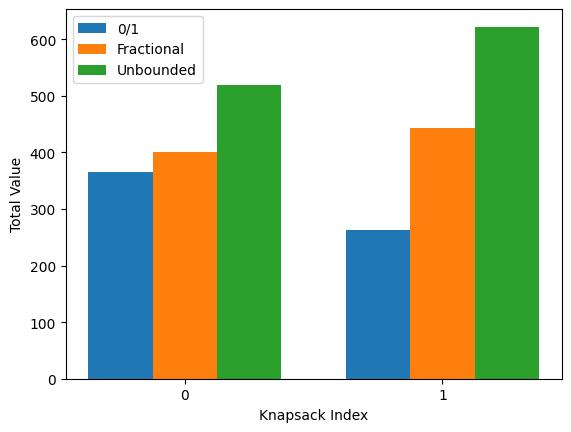

In [8]:

vals_01 = (solution_01 * VALUES).sum(axis=1)
vals_frac = (solution_frac * VALUES).sum(axis=1)
vals_unb = (solution_unb * VALUES).sum(axis=1)

fig, ax = plt.subplots()
x = np.arange(NUM_KNAPSACKS)
width = 0.25
ax.bar(x - width, vals_01, width, label='0/1')
ax.bar(x, vals_frac, width, label='Fractional')
ax.bar(x + width, vals_unb, width, label='Unbounded')
ax.set_xticks(x)
ax.set_xlabel('Knapsack Index')
ax.set_ylabel('Total Value')
ax.legend()
plt.show()
